# Variational Non-linear LFM

In order to run this notebook yourself, you will need the dataset located here:
- Go to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100099

- Download the file `GSE100099_RNASeqGEO.tsv.gz`

In [57]:
import torch
from torch.nn import Parameter
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal

from lafomo.models import OrdinaryLFM, MultiOutputGP
from lafomo.trainer import TranscriptionalTrainer
from lafomo.utilities.torch import save, load, softplus
from lafomo.configuration import VariationalConfiguration
from lafomo.datasets import HafnerData
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

import numpy as np


13
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]) tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


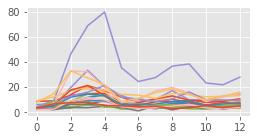

In [58]:
dataset = HafnerData(replicate=0, data_dir='../../../data/', extra_targets=False)
num_replicates = 1
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]
print(num_times)
print(dataset[0][0], dataset.t)
t_inducing = torch.linspace(0, 12, num_times, dtype=torch.float64)
t_observed = torch.linspace(0, 12, num_times)
t_predict = torch.linspace(-2, 14, 80, dtype=torch.float64)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
]).view(num_replicates, num_genes, num_times)

plt.figure(figsize=(4, 2))
for i in range(22):
    plt.plot(dataset[i][1])

In [60]:
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, gp_model, config: VariationalConfiguration, dataset):
        super().__init__(gp_model, config, dataset)
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.basal_rate = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        return softplus(f).repeat(1, self.num_outputs, 1)

    def predict_f(self, t_predict):
        # Sample from the latent distribution
        q_f = super().predict_f(t_predict)
        f = q_f.sample(torch.Size([500])).permute(0, 2, 1)  # (S, I, T)
        print(f.shape)
        # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
        f = torch.mean(self.G(f), dim=0)[0].unsqueeze(0)
        print(f.shape, q_f.mean.shape, q_f.scale_tril.shape)
        batch_mvn = MultivariateNormal(f, q_f.covariance_matrix.unsqueeze(0))
        print(batch_mvn)
        return MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

class ExpTranscriptionLFM(TranscriptionLFM):

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        return torch.exp(f).repeat(1, self.num_outputs, 1)

In [68]:
config = VariationalConfiguration(
    learn_inducing=False,
    num_samples=70,
    kernel_scale=False,
    initial_conditions=False # TODO
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float32)

gp_model = MultiOutputGP(inducing_points, num_tfs)
lfm = TranscriptionLFM(gp_model, config, dataset)
plotter = Plotter(lfm, np.array(dataset.gene_names))

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.05)
trainer = TranscriptionalTrainer(lfm, optimizer, dataset)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\torch\optim\adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


### Outputs prior to training:

torch.Size([22, 80])
torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


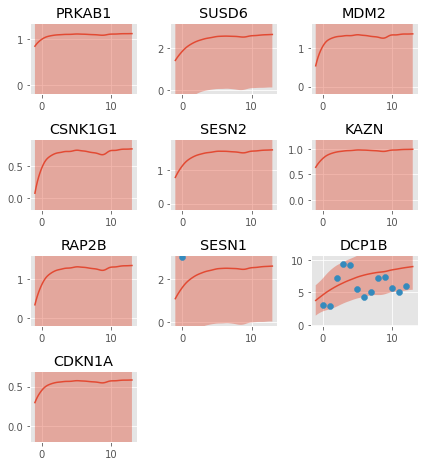

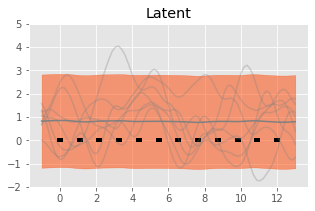

In [69]:
plotter.plot_outputs(t_predict,
                     t_scatter=t_observed,
                     y_scatter=m_observed,
                     model_kwargs=dict(step_size=1e-1))
plotter.plot_latents(t_predict,
                     ylim=(-2, 5),
                     plot_barenco=False,
                     plot_inducing=False)

In [70]:
tol = 1e-1
# trainer = Trainer(optimizer)
output = trainer.train(200, step_size=1e-1, report_interval=10)

Epoch 001/200 - Loss: 1158.90 (1158.90  0.00  ) λ: 0.7443966865539551
Epoch 006/200 - Loss: 809.54 (809.22  0.32  ) λ: 0.8110484480857849
Epoch 011/200 - Loss: 559.97 (559.31  0.66  ) λ: 0.9590900540351868
Epoch 016/200 - Loss: 334.48 (333.52  0.96  ) λ: 1.0821518898010254
Epoch 021/200 - Loss: 223.52 (222.24  1.28  ) λ: 1.0417773723602295
Epoch 026/200 - Loss: 222.38 (220.77  1.61  ) λ: 1.173802375793457
Epoch 031/200 - Loss: 171.43 (169.39  2.04  ) λ: 1.3815348148345947
Epoch 036/200 - Loss: 139.03 (136.76  2.28  ) λ: 1.245195984840393
Epoch 041/200 - Loss: 119.61 (117.01  2.59  ) λ: 1.138968586921692
Epoch 046/200 - Loss: 109.61 (106.73  2.87  ) λ: 1.090211272239685
Epoch 051/200 - Loss: 101.28 (98.21  3.06  ) λ: 1.004391074180603
Epoch 056/200 - Loss: 94.86 (91.61  3.25  ) λ: 1.012208104133606
Epoch 061/200 - Loss: 91.43 (88.01  3.42  ) λ: 1.0075197219848633
Epoch 066/200 - Loss: 88.24 (84.68  3.56  ) λ: 1.0068427324295044
Epoch 071/200 - Loss: 85.32 (81.63  3.69  ) λ: 1.0333968400

### Outputs after training

torch.Size([22, 80])
torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


ValueError: x and y can be no greater than 2-D, but have shapes (200,) and (200, 1, 1, 1)

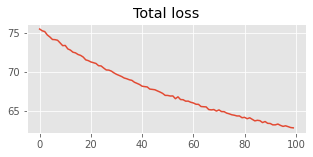

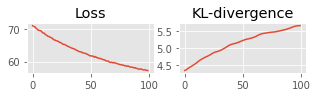

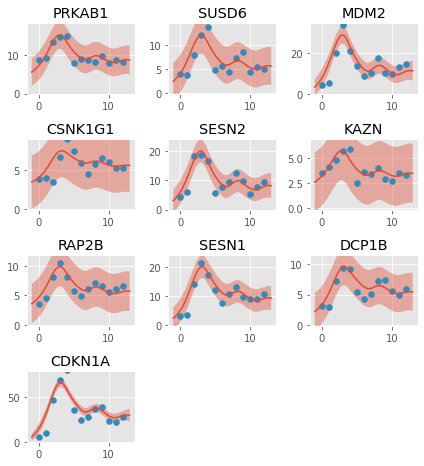

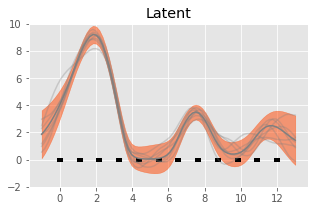

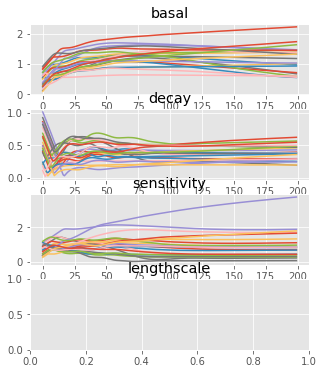

In [79]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict,
                     replicate=0,
                     t_scatter=t_observed,
                     y_scatter=m_observed,
                     model_kwargs=dict(step_size=1e-1))
plotter.plot_latents(t_predict,
                     ylim=(-2, 10),
                     plot_inducing=False)

plotter.plot_convergence(trainer)

In [ ]:
save(model, 'nonlinear')

In [8]:
do_load = False
if do_load:
    model = load('nonlinear', NonLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = TranscriptionalTrainer(model, optimizer, dataset)
